In [135]:
import numpy as np
import matplotlib.pyplot as plt
import models as mod
import mod_visualization as mv

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
from IPython.display import clear_output
def clf():
    clear_output(wait=True)

# 1D
---

**Settings**

In [139]:
N = 10
Nj = 20
T = 20*1000

## Input

In [271]:
# input spikes
Sj = np.random.binomial(1, 10/1000, size=(T, Nj, 1))

bin_size = 1500

i = 0
j = 0
for t0 in range(0, T, bin_size+100):
    if i == N:
        break
    Sj[t0: t0 + bin_size, j] = np.random.binomial(1, 300/1000, size=(bin_size, 1))
    i += 1
    j += 1

In [246]:
# input spikes
Sj = np.random.normal(0, 0.1, (T, Nj, 1)).clip(0, 1)

bin_size = 500

i = 0
j = 0
for t0 in range(0, T, bin_size+100):
    if i == N:
        break
    Sj[t0: t0 + bin_size, j] = np.random.normal(0, 1., size=(bin_size, 1)).clip(0, 1)
    i += 1
    j += 1

## Model 

In [302]:
net = mod.Network(N=N, Nj=Nj, learnable=True, lr=3e-2, 
                  wr_const=3.75,
                  wff_const=5.5,
                  wff_max=4.,
                  wff_min=0.1,
                  wff_beta=0.02,
                  wff_tau=50,
                  wff_rec=65,
                  tau_u=55,
                  syn_ff_min=0.04,
                 )

2023-11-07 18:58:24 | Network(N=10, Nj=20)


#### Connectivity

2023-11-07 18:58:25 | Recurrent weights set (10, 10)


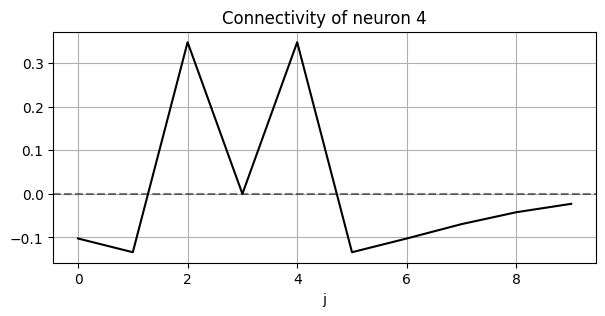

In [303]:
w = mod.mexican_hat_1D(N=N, A=1., B=.045, sigma_exc=.5, sigma_inh=3)

net.set_wrec(w)
#mv.plot_weight_matrix(net.Wrec)

plt.figure(figsize=(7, 3))
plt.axhline(0, color="black", alpha=0.5, linestyle='--')
plt.plot(range(N), net.Wrec[3], '-k')
plt.title("Connectivity of neuron 4")
plt.xlabel("j")
plt.grid()
plt.show()

## Simulation

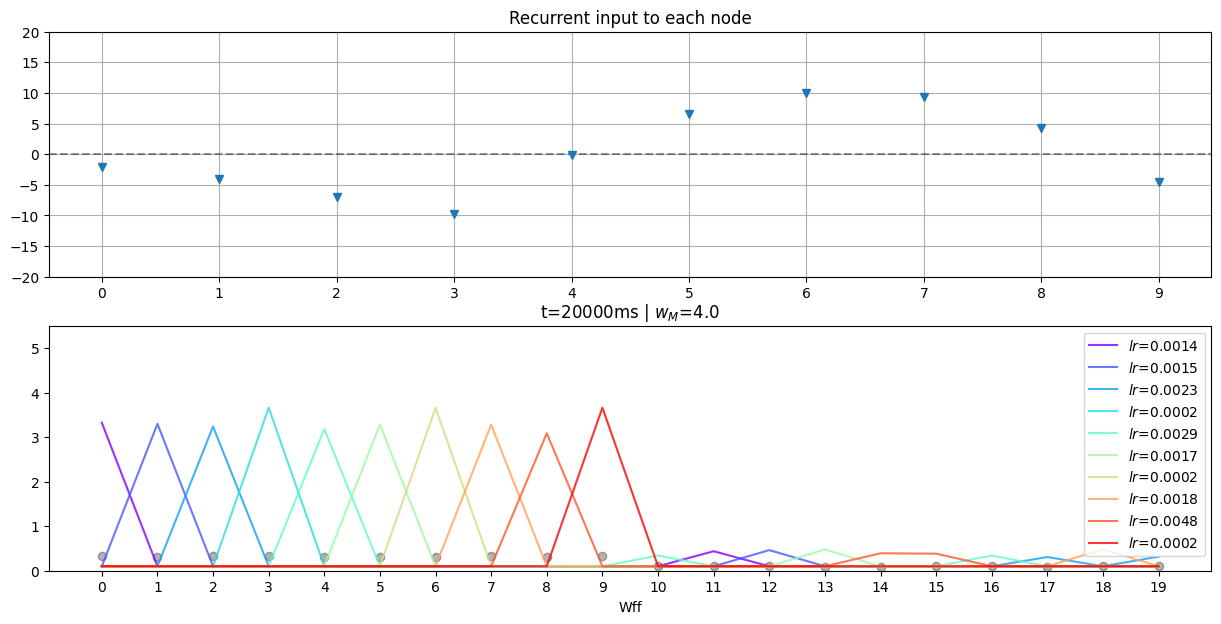

.


In [304]:
net.reset()

tp = 200

sp = np.zeros(Nj)
for t in range(T):

    net.step(Sj=Sj[t])
    sp += Sj[t, :, 0]

    #plt.clf()
    if t%tp == 0:
        clf()
        fig = plt.figure(figsize=(15, 7))

        plt.subplot(211)
        plt.axhline(0, color="black", linestyle="--", alpha=0.4)
        plt.plot(range(N), net.record[:, 1], 'v')
        plt.ylim((-20, 20))
        plt.grid()
        plt.xticks(range(N))
        plt.title("Recurrent input to each node")

        plt.subplot(212)
        plt.plot(range(Nj), sp / (t+1) * 10, 'ok', alpha=0.3)

        for i in range(N):
            plt.plot(range(Nj), net.Wff[i], alpha=0.8, color=net.colors[i],
                     label=f"$lr$={net._lr[i, 0]:.4f}")
        plt.xlabel("Wff")
        plt.title(f"t={t+tp}ms | $w_M$={net.wff_max}")
        plt.ylim((0, 5.5))
        plt.xticks((range(Nj)))
        plt.legend(loc="upper right")
        plt.pause(0.01)

print(".")

# 2D
---

**Settings**

In [129]:
N = 16
Nj = 36
T = 10*1000

## Input
Grid of input neuron, and a trajectory

In [ ]:
# input spikes
Sj = np.random.binomial(1, 10/1000, size=(T, Nj, 1))

bin_size = 1500

i = 0
j = 0
for t0 in range(0, T, bin_size+100):
    if i == N:
        break
    Sj[t0: t0 + bin_size, j] = np.random.binomial(1, 300/1000, size=(bin_size, 1))
    i += 1
    j += 1

# Connectivity
---

**1D**

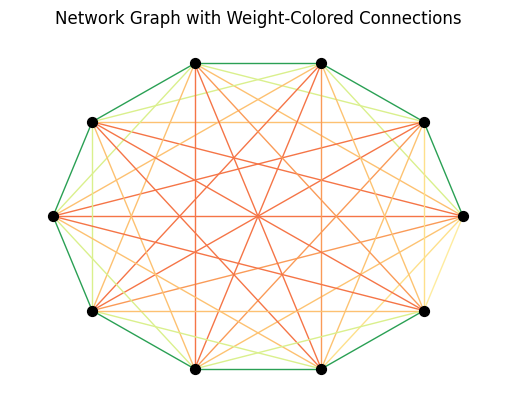

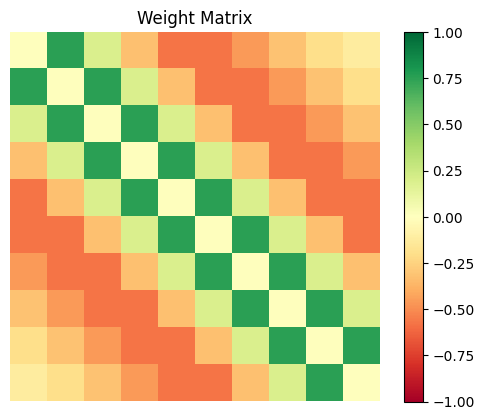

In [44]:
# Generate the Mexican hat connectivity pattern for the smaller network
w = mod.mexican_hat_1D(N=10, A=2.5, B=1.5, sigma_exc=2, sigma_inh=4.)

# plot
mv.plot_graph_colored_1D(w)
mv.plot_weight_matrix(w)

**2D**

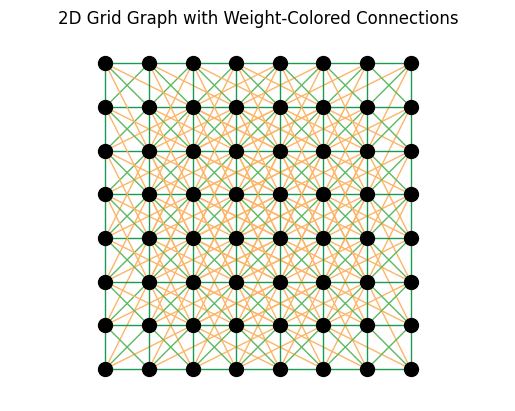

In [72]:
# Define a smaller network for clearer visualization
dims = (8, 8)
A = 2.  # Excitatory strength
B = 1.  # Inhibitory strength
sigma_exc = 2.0  # Excitatory spread
sigma_inh = 4.0  # Inhibitory spread

# Generate the Mexican hat connectivity pattern for the smaller network
w = mod.mexican_hat_2D(dims, A, B, sigma_exc, sigma_inh)

# plot
mv.plot_graph_colored_2D(w, dims, threshold=0.37)

In [294]:
soft = lambda x, b: np.exp(b*x) / np.exp(b*x).sum(axis=0)

In [307]:

sw = soft(w, b=0.05)
print(w, '\n\nsoftmax:\n', np.around(sw, 3), '\n\nmultiplers:\n', sw / sw.max(axis=0))

[[0.        0.        2.        0.        0.       ]
 [0.        0.        0.        0.        2.       ]
 [0.2657752 0.        1.7342248 0.        0.       ]] 

softmax:
 [[0.332 0.333 0.346 0.333 0.322]
 [0.332 0.333 0.313 0.333 0.356]
 [0.336 0.333 0.341 0.333 0.322]] 

multiplers:
 [[0.98679915 1.         1.         1.         0.90483742]
 [0.98679915 1.         0.90483742 1.         1.        ]
 [1.         1.         0.98679915 1.         0.90483742]]


In [278]:
sw / sw.max(axis=0) * w

array([[0.        , 0.        , 2.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 2.        ],
       [0.2657752 , 0.        , 1.32947658, 0.        , 0.        ]])

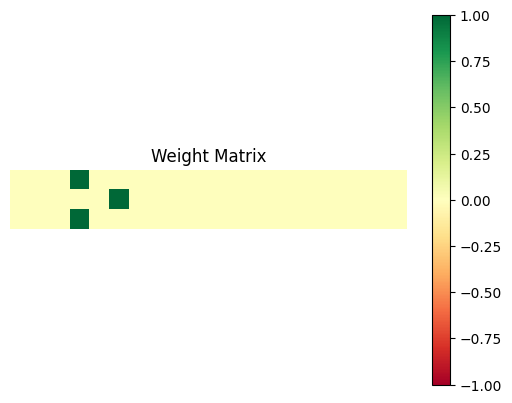

In [233]:
mv.plot_weight_matrix(net.Wff)